# Modèle LassoCV

Régression linéaire régularisée à l’aide de la méthode Lasso (régularisation L1), qui choisit automatiquement la meilleure valeur du paramètre de régularisation noté alpha en utilisant plusieurs plis pour la validation croisée

## Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import os 
import importlib
from RegressorModel import RegressorModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Définition des fonctions de sauvegarde

In [2]:
def modelAlreadyTrain(filename):
    return os.path.isfile('../models/' + filename)

def savePickleModel(model, filename):
    with open('../models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

def loadPickleModel(filename):
    with open('../models/' + filename, 'rb') as f:
        model = pickle.load(f)
        f.close()
        return model

## Création des jeux de données d'entrainement et de test

In [3]:
df=pd.read_csv('../Data/Processed/Co2_final.csv')
X = df.drop(columns=['Ewltp (g/km)', 'ID'])
y = df['Ewltp (g/km)']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Entrainement du modèle

In [4]:
if modelAlreadyTrain('LassoCVRegressor.pkl') :
    lasso_cv = loadPickleModel('LassoCVRegressor.pkl')
else:
    lasso_cv=LassoCV(cv = 10,
                     random_state=42,
                     n_jobs=-1)
    lasso_cv.fit(X_train, y_train)
    savePickleModel(lasso_cv, 'LassoCVRegressor.pkl')


### Affichage des paramètres

In [5]:
params = lasso_cv.get_params()
print(params)

{'alphas': None, 'copy_X': True, 'cv': 10, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': -1, 'positive': False, 'precompute': 'auto', 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}


### Affichage de l'évolution de l'erreur quadratique moyenne en fonction d'alpha


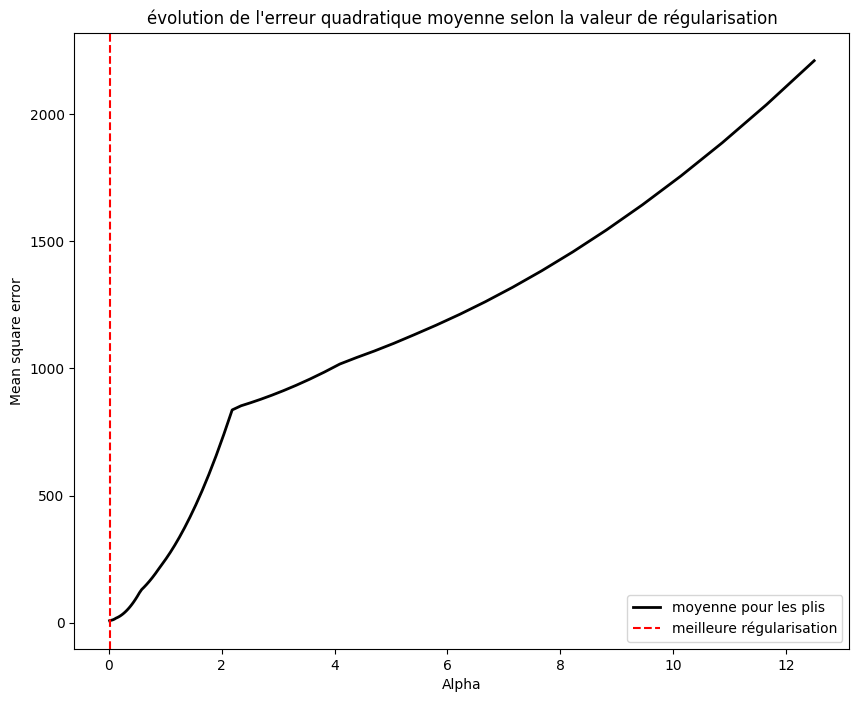

In [6]:
    
alphas = lasso_cv.alphas_
plt.figure(figsize = (10, 8))
plt.plot(alphas, lasso_cv.mse_path_.mean(axis = 1), 'k', label = 'moyenne pour les plis', linewidth = 2)
plt.axvline(lasso_cv.alpha_, linestyle = '--', color = 'red', label = 'meilleure régularisation')
plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('évolution de l\'erreur quadratique moyenne selon la valeur de régularisation')
plt.legend();

In [7]:
print("Meilleur paramètre de régularisation trouvé, alpha =", lasso_cv.alpha_)

Meilleur paramètre de régularisation trouvé, alpha = 0.01250362223179284


## Résultats du LassoCV

### Affichage du RMSE et du score R²

In [7]:

LassoCVModel = RegressorModel('LassoCV', lasso_cv, X_train, X_test, y_train, y_test, X.columns)
LassoCVModel.predictModel()
LassoCVModel.calcScore()
LassoCVModel.displayScore()

RMSE Jeux d entrainement : 2.715101108152543
RMSE Jeux de test : 2.6748785817260843
Score du modèle train (R²) 0.9966665248912118
Score du modèle test (R²) 0.9967561452850051


### Graphique des résultats en représentant sur l'axe y les valeurs prédites et sur l'axe x la valeur rééle

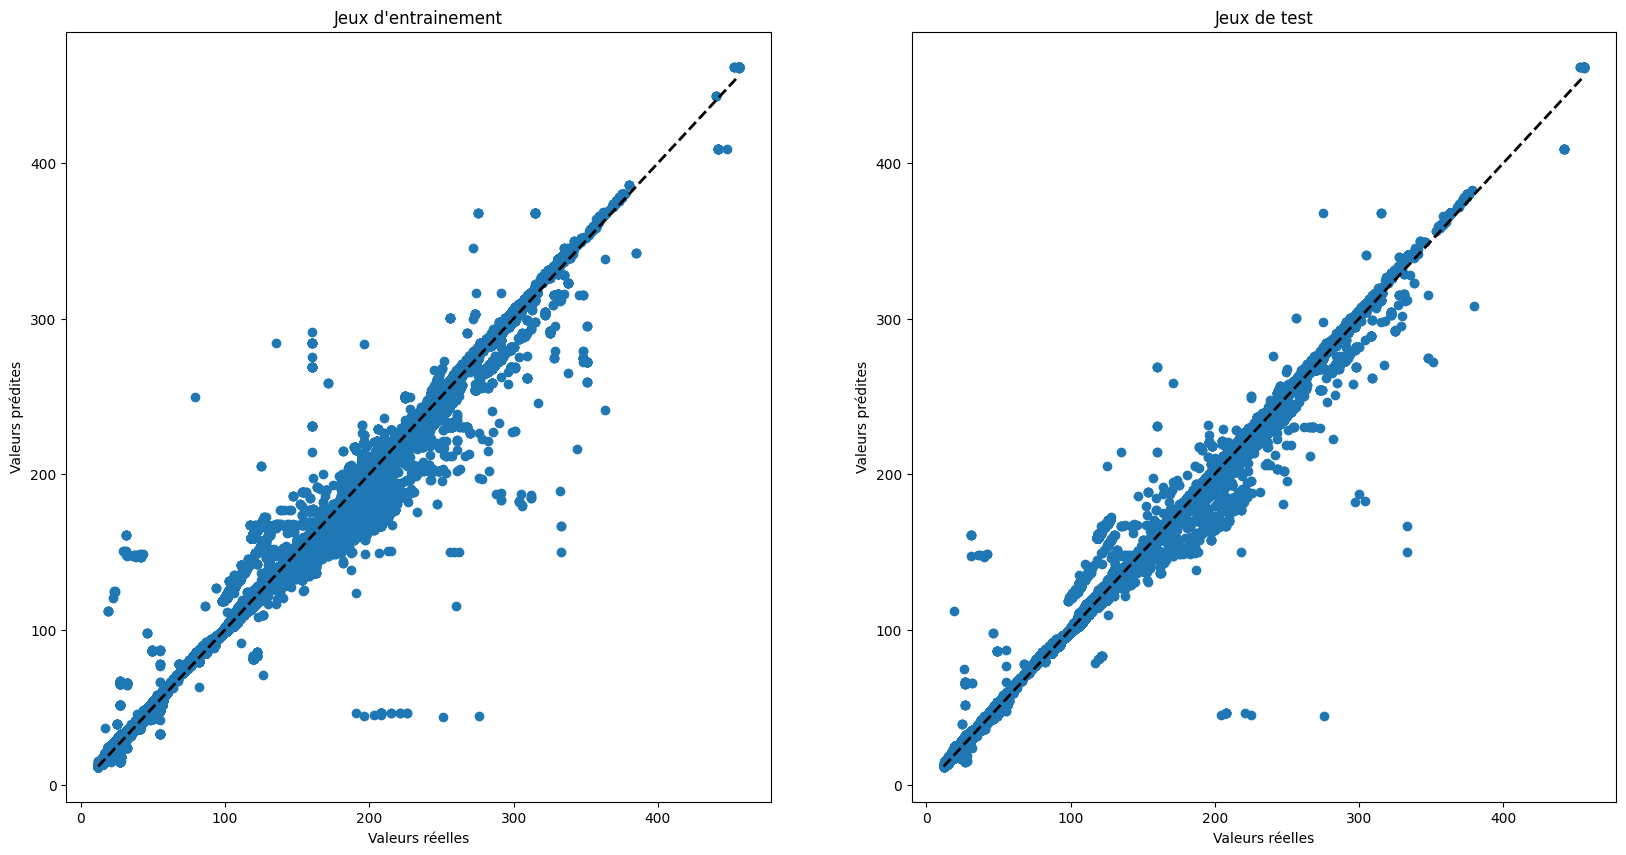

In [8]:
LassoCVModel.displayGraphResultVsReel()

### Affichage de la distribution de la différence entre la valeur prédite et la valeur réelle

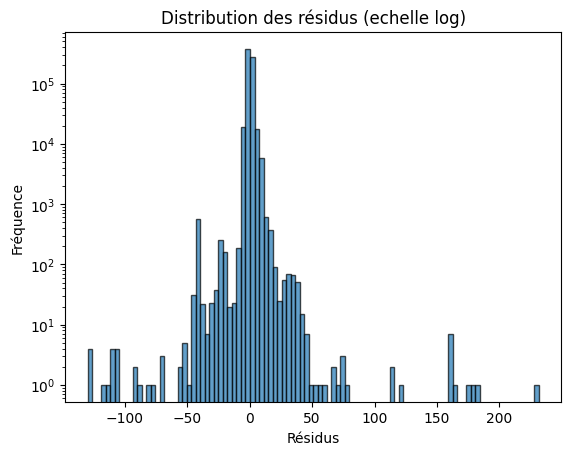

In [9]:
LassoCVModel.displayDistributionOfResidue(True)

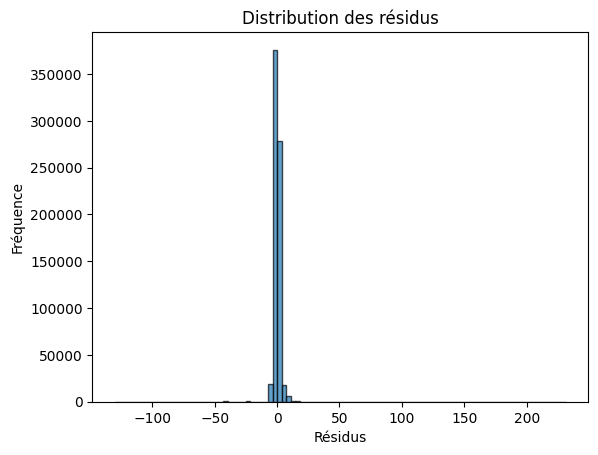

In [10]:
LassoCVModel.displayDistributionOfResidue(False)

## Interprétation du modèle

### Importance des caractéristiques

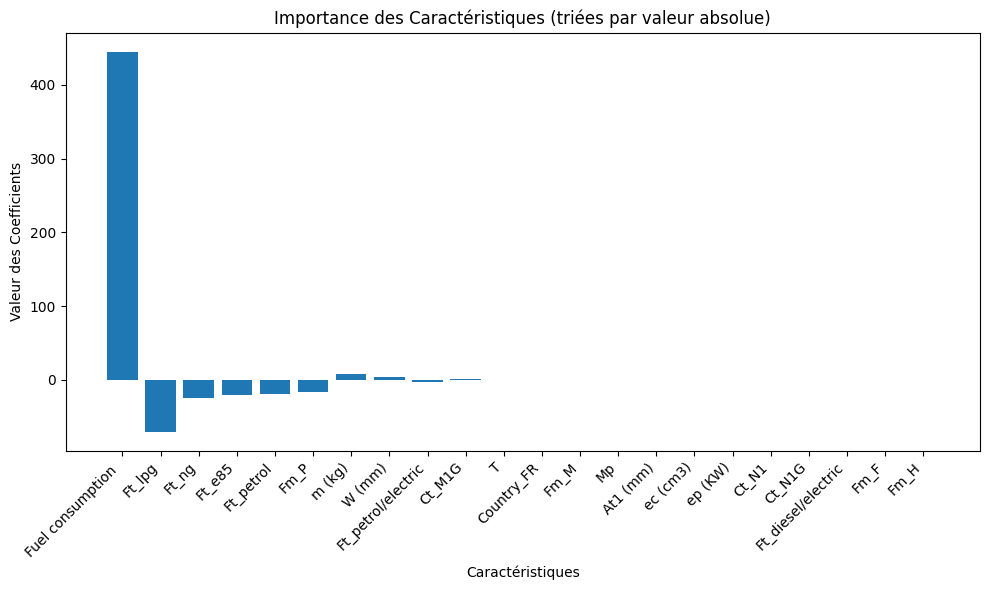

In [11]:
LassoCVModel.displayFeatureImportances()

### Tableau des statistiques des coefficients classés

In [12]:
coeffs = list(lasso_cv.coef_)
coeffs.insert(0, lasso_cv.intercept_)
feats = list(X.columns)
feats.insert(0, 'intercept')
pd.DataFrame({'valeur estimée': coeffs}, index=feats)

f_stat, p_value = f_regression(X_train, y_train)

resultats = pd.DataFrame({
    'Caractéristiques': feats,
    'Coefficient': coeffs,
    'F-statistique': [None] + list(f_stat),
    'P-value': [None] + list(p_value)
})

feature_importances = resultats.copy()
feature_importances['Abs_Coefficient'] = resultats['Coefficient'].apply(abs)
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')
print(feature_importances)

      Caractéristiques  Coefficient  F-statistique        P-value
8    Fuel consumption    444.615460   4.148465e+07   0.000000e+00
15              Ft_lpg   -70.024798   1.519098e+03   0.000000e+00
0            intercept    28.104137            NaN            NaN
16               Ft_ng   -24.761508   2.287061e+02   1.147033e-51
14              Ft_e85   -21.053810   9.094831e+01   1.475859e-21
17           Ft_petrol   -18.471525   3.109143e+05   0.000000e+00
22                Fm_P   -16.549914   4.198083e+06   0.000000e+00
3               m (kg)     7.883077   9.833576e+02  8.115883e-216
4               W (mm)     4.176554   1.151305e+05   0.000000e+00
18  Ft_petrol/electric    -3.209182   3.682461e+06   0.000000e+00
10              Ct_M1G     1.152504   3.354721e+04   0.000000e+00
2                    T    -0.620931   1.875715e+04   0.000000e+00
9           Country_FR    -0.392088   4.123776e+04   0.000000e+00
21                Fm_M     0.310626   7.332045e+05   0.000000e+00
1         

### Analyse SHAP (SHapley Additive exPlanations)

In [13]:
import shap
X_test_sample = X_test[:5000]
explainer = shap.Explainer(lasso_cv, X_test_sample)
shap_values = explainer(X_test_sample)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


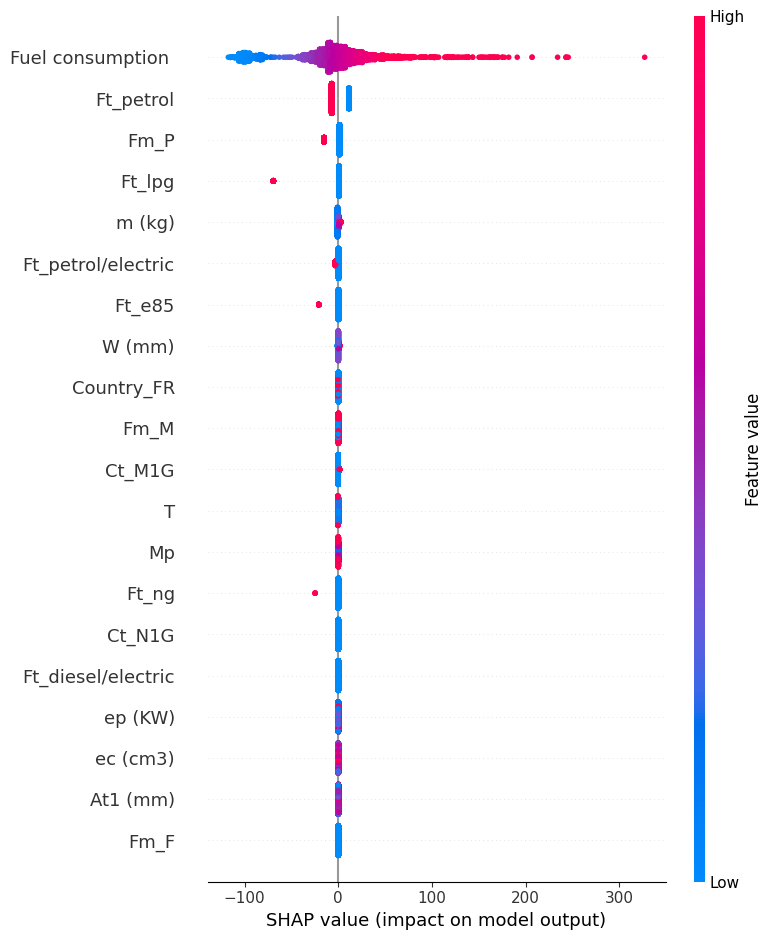

In [14]:
shap.summary_plot(shap_values,
                X_test_sample,
                feature_names=X.columns
                )

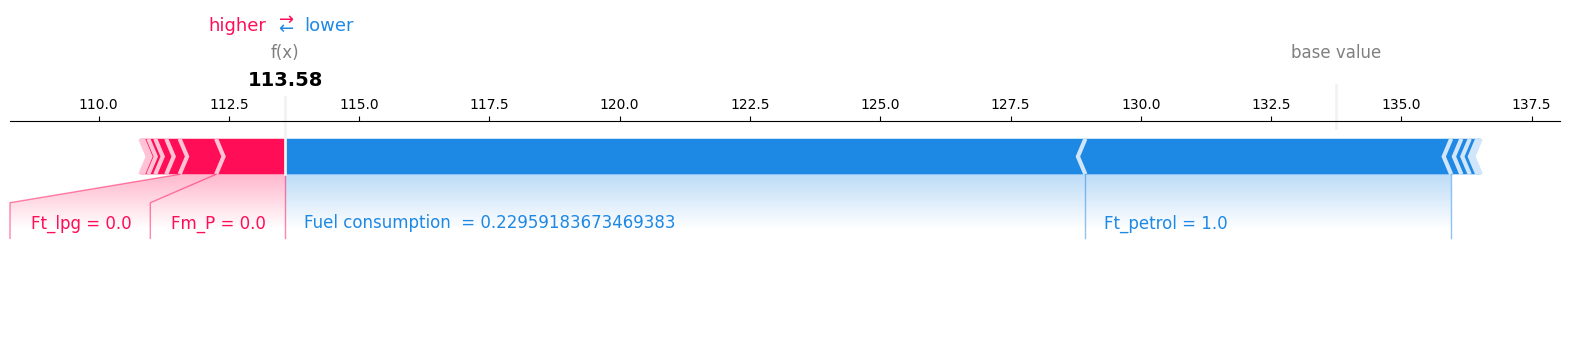

In [15]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0].values,
    X_test_sample[0],
    feature_names=X.columns,
    matplotlib=True,
)